In [1]:
from keras.layers import Lambda, Input, Dense, Reshape, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, CategoricalCrossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm
from keras.metrics import categorical_crossentropy

import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score
from sklearn.metrics import completeness_score, silhouette_score, mean_squared_error

import pandas as pd
import numpy as np
import xarray as xr

from scipy import stats
import xesmf as xe
from math import ceil

import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

import clustering_functions as cf
import skill_scores as sc
from datetime import datetime, timedelta

2024-09-25 19:26:54.864788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]
winter_months = [12, 1, 2]
years = list(range(1940, 2023))
#np.random.seed(0)

### Parameters

In [3]:
import yaml
from yaml import CLoader as Loader

cluster_number = 5

stream = open("results.nosync/model_specifications_and_results/cmm_vae/v924.yaml", 'r')
dictionary = yaml.load(stream, Loader=Loader)

pr_cluster_number = dictionary['pr_cluster_number']

#filepath = dictionary['filepath']
filepath = "results.nosync/model_specifications_and_results/cmm_vae/v924/v1/s2s/"

original_dim = dictionary['original_dim']
inputdim1 = dictionary['inputdim1']
inputdim2 = dictionary['inputdim2']

latent_dim = dictionary['latent_dim']

activation_function = dictionary['activation_function']

dim_layer1 = dictionary['dim_layer1']
dim_layer2 = dictionary['dim_layer2']
dim_layer3 = dictionary['dim_layer3']

cat_dim = dictionary['cat_dim']

batch_size = dictionary['batch_size']
epochs = dictionary['epochs']

reconstruction_loss_factor = 0.5

In [4]:
input_shape = (original_dim, )

input_shape_r = (pr_cluster_number, )

**Define sampling function**

In [5]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

#### Import previous data

In [6]:
# mediterranean
#z500 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
#                              variable_name = 'z', 
#                              multiplication_factor = 1/g0, 
#                              geographical_filter = 'mediterranean', 
#                              months_filter = extended_winter_months, 
#                              anomalies = True, 
#                              normalization = True,
#                              rolling_window = 5)#

#z500 = z500.where(z500['time.year'] > 1980, drop=True)

In [7]:
# atlantic

z500 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

In [8]:
pr_labels = pd.read_csv('results.nosync/CHIRPS_precip_targets/clusters_labels_5.csv')
pr_labels.columns = ['index', 'labels']
pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

## Define model

**Encoder**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 encoder_intermediate (Dens  (None, 256)                  211456    ['encoder_input[0][0]']       
 e)                                                                                               
                                                                                                  
 encoder_intermediate_2 (De  (None, 128)                  32896     ['encoder_intermediate[0][0]']
 nse)                                                                                             
                                                                                            

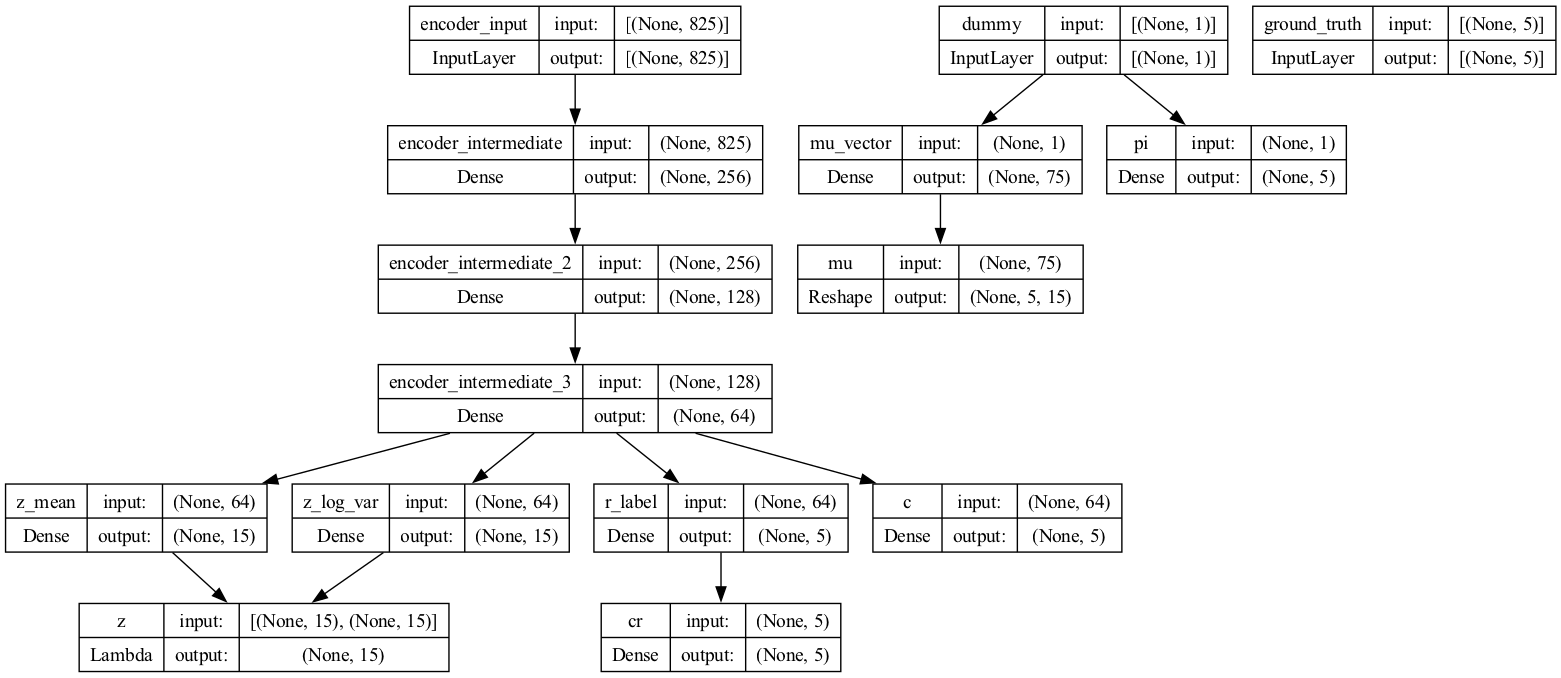

In [9]:
inputs_x = Input(shape=input_shape, name='encoder_input')
inputs_r = Input(shape=input_shape_r, name='ground_truth')

inter_x1 = Dense(dim_layer1, activation=activation_function, name='encoder_intermediate')(inputs_x)
inter_x2 = Dense(dim_layer2, activation=activation_function, name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(dim_layer3, activation=activation_function, name='encoder_intermediate_3')(inter_x2)

dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(cluster_number*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((cluster_number,latent_dim), name='mu')(mu_vector)

pi = Dense(cluster_number, activation='softmax', name='pi')(dummy)
c = Dense(cluster_number, activation='softmax', name='c')(inter_x3)

z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

r = Dense(pr_cluster_number, name='r_label', activation='softmax')(inter_x3)

cr = Dense(cluster_number, activation='softmax', name='cr')(r)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,dummy, inputs_r], [z_mean, z_log_var, z, mu, c, pi, r, cr], name='encoder')

encoder.summary()
plot_model(encoder, show_shapes=True, dpi=100)

**Decoder**

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 825)               212025    
                                                                 
Total params: 254393 (993.72 KB)
Trainable params: 254393 (993.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


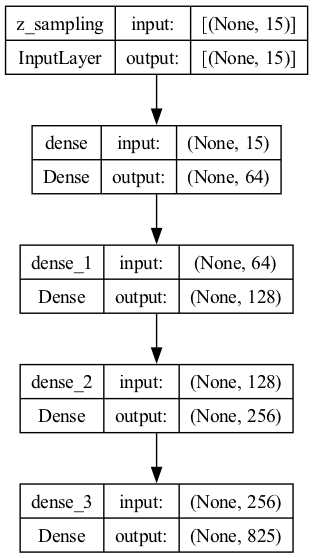

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(dim_layer3, activation=activation_function)(latent_inputs)
inter_y2 = Dense(dim_layer2, activation=activation_function)(inter_y1)
inter_y3 = Dense(dim_layer1, activation=activation_function)(inter_y2)

outputs = Dense(original_dim)(inter_y3)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, dpi=100)

**combine encoder and decoder to VAE model and print summary**

In [11]:
outputs = decoder(encoder([inputs_x, dummy, inputs_r])[2])

vae = Model([inputs_x,dummy, inputs_r], outputs, name='vae_classification')

vae.summary()

Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255323    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0]

### Loss function

In [12]:
reconstruction_loss = mse(inputs_x, outputs)*original_dim*reconstruction_loss_factor

prediction_loss = categorical_crossentropy(c, cr)

target_loss = (categorical_crossentropy(inputs_r, r) + categorical_crossentropy(r, r))*pr_cluster_number

kl_loss_all = tf.compat.v1.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)

kl_cat_all = tf.compat.v1.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
dir_prior_all = tf.compat.v1.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=tf.float32,initializer=tf.zeros_initializer)

for i in range(0,cluster_number):
    
    kl_loss = 1 + z_log_var - tf.math.square(z_mean-mu[:,i,:]) - tf.math.exp(z_log_var)
    kl_loss = tf.multiply(tf.reduce_sum(kl_loss, axis=-1), c[:,i])
    kl_loss = -0.5*(kl_loss)
    kl_loss_all = kl_loss_all + kl_loss
    
    mc = tf.reduce_mean(c[:,i])
    mpi = tf.reduce_mean(pi[:,i])
    kl_cat = mc * tf.math.log(mc)- mc * tf.math.log(mpi)
    kl_cat_all = kl_cat_all+kl_cat
    
    dir_prior = -tf.math.log(pi[:,i])*0.5
    dir_prior_all = dir_prior_all + dir_prior

**Set loss function for model**

In [13]:
vae_loss = K.mean(reconstruction_loss+prediction_loss+target_loss+kl_loss_all+kl_cat_all+dir_prior_all)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.save_weights(filepath+'TEST_random_weights_'+str(cluster_number)+'.h5')

Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255323    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0]

                                                                                                  
 pi (Dense)                  (None, 5)                    10        ['dummy[0][0]']               
                                                                                                  
 tf.math.subtract_2 (TFOpLa  (None, 15)                   0         ['tf.math.subtract_1[0][0]',  
 mbda)                                                               'tf.math.exp[0][0]']         
                                                                                                  
 tf.math.subtract_5 (TFOpLa  (None, 15)                   0         ['tf.__operators__.add_5[0][0]
 mbda)                                                              ',                            
                                                                     'tf.math.square_1[0][0]']    
                                                                                                  
 tf.math.e

 tf.math.subtract_10 (TFOpL  (None, 15)                   0         ['tf.math.subtract_9[0][0]',  
 ambda)                                                              'tf.math.exp_2[0][0]']       
                                                                                                  
 tf.math.subtract_13 (TFOpL  (None, 15)                   0         ['tf.__operators__.add_13[0][0
 ambda)                                                             ]',                           
                                                                     'tf.math.square_3[0][0]']    
                                                                                                  
 tf.math.exp_3 (TFOpLambda)  (None, 15)                   0         ['z_log_var[0][0]']           
                                                                                                  
 tf.__operators__.add_17 (T  (None, 15)                   0         ['z_log_var[0][0]']           
 FOpLambda

 7 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_1  (None,)                      0         ['pi[0][0]']                  
 8 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.math.log_2 (TFOpLambda)  (None,)                      0         ['tf.__operators__.getitem_4[0
                                                                    ][0]']                        
                                                                                                  
 tf.__operators__.getitem_9  (None,)                      0         ['pi[0][0]']                  
  (SlicingOpLambda)                                                                               
          

                                                                                                  
 tf.cast_1 (TFOpLambda)      (None, 5)                    0         ['c[0][0]']                   
                                                                                                  
 tf.convert_to_tensor_1 (TF  (None, 5)                    0         ['cr[0][0]']                  
 OpLambda)                                                                                        
                                                                                                  
 tf.keras.backend.categoric  (None,)                      0         ['tf.cast_2[0][0]',           
 al_crossentropy_1 (TFOpLam                                          'tf.convert_to_tensor_4[0][0]
 bda)                                                               ']                            
                                                                                                  
 tf.keras.

 tf.math.multiply_19 (TFOpL  (None,)                      0         ['tf.math.multiply_18[0][0]'] 
 ambda)                                                                                           
                                                                                                  
 tf.math.multiply_23 (TFOpL  (None,)                      0         ['tf.math.reduce_sum_4[0][0]',
 ambda)                                                              'tf.__operators__.getitem_21[
                                                                    0][0]']                       
                                                                                                  
 tf.__operators__.add_7 (TF  (128, 1)                     0         ['tf.__operators__.add_3[0][0]
 OpLambda)                                                          ',                            
                                                                     'tf.math.subtract_7[0][0]']  
          

                                                                     'tf.math.multiply_2[0][0]']  
                                                                                                  
 tf.__operators__.add_18 (T  (128, None)                  0         ['tf.__operators__.add_14[0][0
 FOpLambda)                                                         ]',                           
                                                                     'tf.math.multiply_24[0][0]'] 
                                                                                                  
 tf.__operators__.add_15 (T  (128, 1)                     0         ['tf.__operators__.add_11[0][0
 FOpLambda)                                                         ]',                           
                                                                     'tf.math.subtract_15[0][0]'] 
                                                                                                  
 tf.math.s

### Trial model once with random weights

In [14]:
X_trialrun = cf.reshape_data_for_clustering(z500)
y_trialrun = label_indices
dummy_full_trialrun = np.ones((X_trialrun.shape[0],1))

In [15]:
vae.load_weights(filepath+'TEST_random_weights_'+str(cluster_number)+'.h5')

vae.fit([X_trialrun,dummy_full_trialrun, y_trialrun], epochs=200, 
              batch_size=batch_size, 
              verbose=0)

In [16]:
chosen_count = 1
vae.load_weights(filepath+'../weights/final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')
[z_mean_enc_trialrun, z_log_var_enc_trialrun, z_enc_trialrun, mu_enc_trialrun, c_enc_trialrun, pi_enc_trialrun, r_enc_trialrun, cr_enc_trialrun] = encoder.predict([X_trialrun,dummy_full_trialrun, y_trialrun],batch_size=batch_size)


50/50 [==============================] - 0s 3ms/step


## Now start with forecast data

In [17]:
chosen_count = 1
cluster_number = 5

reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

conditional_probabilities_ls = []
mse_ls = []
cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    #ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std()
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] < 45, drop=True)
    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] > -50.5, drop=True)
    ds_days_anom = ds_days_anom*weights
    
    for leadtime in range(47):
        
        c_ls = []
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]
            nt,ny,nx = selected.values.shape

            X = cf.reshape_data_for_clustering(selected)
            y = label_indices[0:41, :]
            dummy_full = np.ones((X.shape[0],1))

            vae.load_weights(filepath+'../weights/final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')
            [z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc,cr_enc] = encoder.predict([X,dummy_full, y],batch_size=batch_size)
            X_decoded = decoder.predict(z_enc)
            
            mse_reconstruction = mean_squared_error(X_decoded, X, multioutput='raw_values')
            mse_ls.append(pd.DataFrame(data={'Method': 'CMM-VAE', 'leadtime': leadtime, 'mse': mse_reconstruction}))

            c_ls.append(c_enc)
            
            cluster_labels = np.zeros(X.shape[0])
            for i in range(0, X.shape[0]):
                max_prob = np.max(c_enc[i,:])
                idx = np.argmax(c_enc[i,:])
                cluster_labels[i] = idx
            
            X_decoded = decoder.predict(z_enc)
            reconstructed_space = X_decoded.reshape(nt, ny,nx, order='F')
            reconstructed_space_xr = xr.DataArray(reconstructed_space, coords=selected.coords, 
                             dims=selected.dims, attrs=selected.attrs)
            reconstructed_labeled = reconstructed_space_xr.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            reconstructed_labeled_mean = reconstructed_labeled_mean/weights
            cluster_centers.append(reconstructed_labeled_mean)
        
        c_total = []
        for i in range(cluster_number):
            
            c_total.append(np.mean([c_ls[0][:, i], c_ls[1][:, i], c_ls[2][:, i], c_ls[3][:, i],
                                   c_ls[4][:, i], c_ls[5][:, i], c_ls[6][:, i], c_ls[7][:, i],
                                   c_ls[8][:, i], c_ls[9][:, i], c_ls[10][:, i]], axis=0))
            
            
         
        conditional_probabilities_ls.append(pd.DataFrame(data={'Method': 'CMM-VAE',
                                                                'forecast_init': selected['time'].dt.date,
                                                               'valid_date': selected['time'].dt.date + timedelta(days=leadtime),
                                                               'leadtime': leadtime,
                                                               str(0): c_total[0],
                                                               str(1): c_total[1],
                                                               str(2): c_total[2],
                                                               str(3): c_total[3],
                                                               str(4): c_total[4],
                                                              #str(5): c_total[5],
                                                              #str(6): c_total[6],
                                                              #str(7): c_total[7]
                                                              }))

conditional_probabilities = pd.concat(conditional_probabilities_ls)
mse_total = pd.concat(mse_ls)

conditional_probabilities.to_csv(filepath+'conditional_probabilities_'+str(cluster_number)+'.csv')
mse_total.to_csv(filepath+'mse_round_'+str(cluster_number)+'.csv')

cluster_centers_concat = xr.concat(cluster_centers, "start_date")
s2s_cluster_centers = cluster_centers_concat.mean(dim='start_date')

0101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800108-20200108.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800115-20200115.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800122-20200122.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800201-20200201.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800208-20200208.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800215-20200215.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800222-20200222.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0301


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800301-20200301.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0308


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800308-20200308.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0315


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800315-20200315.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0322


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800322-20200322.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0901


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800901-20200901.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0908


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800908-20200908.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0915


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800915-20200915.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0922


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800922-20200922.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1001


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801001-20201001.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1008


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801008-20201008.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1015


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801015-20201015.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 4ms/step
1022


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801022-20201022.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step
1101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801101-20201101.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801108-20201108.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801115-20201115.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801122-20201122.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step
1201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801201-20201201.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801208-20201208.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801215-20201215.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801222-20201222.grb.923a8.idx' incompatible with GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


In [ ]:
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

def visualise_contourplot_8_s2s(dataset_xarray, unit, regime_names, vmin, vmax, steps, regime_order,
                                color_scheme, col_number=2,borders=True,
                                projection=ccrs.Orthographic(0,45)):
    
    nt,ny,nx = dataset_xarray.values.shape
    x,y = np.meshgrid(dataset_xarray.longitude, dataset_xarray.latitude)

    proj = projection
    fig, axes = plt.subplots(1,col_number, figsize=(14, 5), subplot_kw=dict(projection=proj))

    regimes = regime_names

    for i in regime_order:
        
        count = regime_order[i]
        
        cs = axes.flat[i].contourf(x, y, dataset_xarray[count, :, :],
                                   levels=np.arange(vmin, vmax, steps), 
                                   transform=ccrs.PlateCarree(),
                                   cmap=color_scheme)
        axes.flat[i].coastlines()
        
        if borders==True:
            axes.flat[i].add_feature(cartopy.feature.BORDERS)
            
        title = regimes[i]
        axes.flat[i].set_title(title)
    plt.tight_layout()
    return(fig)

In [ ]:
pca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = s2s_cluster_centers, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-5, vmax=5.5, steps=0.5, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [2, 1, 0, 3, 4],
                                         projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50))


### Forecast data full ensemble

In [18]:
chosen_count = 11

reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

conditional_probabilities_ls = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/s2s_hindcasts_LR/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/s2s_hindcasts_LR/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))
    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] < 45, drop=True)
    
    for leadtime in range(47):
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]

            X = cf.reshape_data_for_clustering(selected)
            y = label_indices[0:41, :]
            dummy_full = np.ones((X.shape[0],1))

            vae.load_weights(filepath+'../weights/final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')
            [z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc,cr_enc] = encoder.predict([X,dummy_full, y],batch_size=batch_size)
            X_decoded = decoder.predict(z_enc)

            conditional_probabilities_ls.append(pd.DataFrame(data={'Method': 'CMM-VAE',
                                                                'forecast_init': selected['time'].dt.date,
                                                               'valid_date': selected['time'].dt.date + timedelta(days=leadtime),
                                                               'leadtime': leadtime,
                                                                   'Member': member,
                                                               str(0): c_enc[:, 0],
                                                               str(1): c_enc[:, 1],
                                                               str(2): c_enc[:, 2],
                                                               str(3): c_enc[:, 3],
                                                               str(4): c_enc[:, 4]}))
            
            
conditional_probabilities = pd.concat(conditional_probabilities_ls)

conditional_probabilities.to_csv(filepath+'k8/conditional_probabilities_allmembers.csv')

Ignoring index file '../data.nosync/s2s_hindcasts_LR/plev_data_perturbed_members_19800101-20200101.grb.923a8.idx' older than GRIB file


0101


Ignoring index file '../data.nosync/s2s_hindcasts_LR/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' older than GRIB file


KeyboardInterrupt: 

In [27]:
conditional_probabilities

Method forecast_init  valid_date  leadtime  Member             0  \
0   CMM-VAE    1980-01-01  1980-01-01         0       0  9.998479e-01   
1   CMM-VAE    1981-01-01  1981-01-01         0       0  9.028693e-10   
2   CMM-VAE    1982-01-01  1982-01-01         0       0  1.766816e-06   
3   CMM-VAE    1983-01-01  1983-01-01         0       0  1.071239e-17   
4   CMM-VAE    1984-01-01  1984-01-01         0       0  8.901782e-09   
..      ...           ...         ...       ...     ...           ...   
36  CMM-VAE    2016-12-22  2017-02-06        46      10  9.999999e-01   
37  CMM-VAE    2017-12-22  2018-02-06        46      10  6.234446e-03   
38  CMM-VAE    2018-12-22  2019-02-06        46      10  8.456398e-05   
39  CMM-VAE    2019-12-22  2020-02-06        46      10  7.679319e-10   
40  CMM-VAE    2020-12-22  2021-02-06        46      10  1.971996e-01   

               1             2             3             4  
0   1.520161e-04  1.832220e-11  1.938123e-16  6.736558e-08  
1   9.999999e-01  5.469964e-30  5.536230e-10  8.518105e-09  
2   1.647864e-11  2.931321e-08  1.165904e-03  9.988323e-01  
3   9.999999e-01  3.748062e-16  5.263151e-12  9.714792e-14  
4   1.851528e-09  4.046769e-01  5.953166e-01  6.462392e-06  
..           ...           ...           ...           ...  
36  2.304111e-13  1.607603e-12  6.692380e-09  2.016628e-09  
37  7.573275e-11  1.665646e-12  2.891271e-05  9.937366e-01  
38  2.448127e-07  4.103946e-02  1.239378e-01  8.349379e-01  
39  1.174176e-11  9.999999e-01  8.440783e-16  2.090069e-13  
40  1.024529e-11  8.919529e-07  3.949932e-09  8.027995e-01  

[593516 rows x 10 columns]

#### ... and another time to get cluster centers

In [17]:
chosen_count = 6

reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))
    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] < 45, drop=True)
    
    for leadtime in range(47):
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]
            nt,ny,nx = selected.values.shape

            X = cf.reshape_data_for_clustering(selected)
            y = label_indices[0:41, :]
            dummy_full = np.ones((X.shape[0],1))

            vae.load_weights(filepath+'../weights/final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')
            [z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc,cr_enc] = encoder.predict([X,dummy_full, y],batch_size=batch_size)
            
            cluster_labels = np.zeros(X.shape[0])
            for i in range(0, X.shape[0]):
                max_prob = np.max(c_enc[i,:])
                idx = np.argmax(c_enc[i,:])
                cluster_labels[i] = idx
            
            X_decoded = decoder.predict(z_enc)
            reconstructed_space = X_decoded.reshape(nt, ny,nx, order='F')
            reconstructed_space_xr = xr.DataArray(reconstructed_space, coords=selected.coords, 
                             dims=selected.dims, attrs=selected.attrs)
            reconstructed_labeled = reconstructed_space_xr.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            
            
            cluster_centers.append(reconstructed_labeled_mean)

Ignoring index file '../data.nosync/plev_data_perturbed_members_19800101-20200101.grb.923a8.idx' older than GRIB file


0101


Ignoring index file '../data.nosync/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' older than GRIB file


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


Ignoring index file '../data.nosync/plev_data_perturbed_members_19800108-20200108.grb.923a8.idx' older than GRIB file


0108
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 3ms/step
0115
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 2ms/step
0122
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step
0201
2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0208
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


2/2 [==============================] - 0s 3ms/step
0215
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 2ms/step
0222
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step
0301
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
0308
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 2ms/step
0315
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


2/2 [==============================] - 0s 2ms/step
0322
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
0901
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step
0908
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 3ms/step
0915
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 2ms/step
0922
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1001
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1008
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 3ms/step
1015
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1022
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
1101
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step
1108
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 2ms/step
1115
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 33ms/step


2/2 [==============================] - 0s 3ms/step
1122
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 268ms/step


2/2 [==============================] - 0s 3ms/step
1201
2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
1208
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 2ms/step
1215
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


2/2 [==============================] - 0s 3ms/step
1222
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


In [21]:
def visualise_contourplot_8_s2s(dataset_xarray, unit, regime_names, vmin, vmax, steps, regime_order,
                                color_scheme, col_number=2,borders=True,
                                projection=ccrs.Orthographic(0,45)):
    
    nt,ny,nx = dataset_xarray.values.shape
    x,y = np.meshgrid(dataset_xarray.longitude, dataset_xarray.latitude)

    proj = projection
    fig, axes = plt.subplots(1,col_number, figsize=(14, 5), subplot_kw=dict(projection=proj))

    regimes = regime_names

    for i in regime_order:
        
        count = regime_order[i]
        
        cs = axes.flat[i].contourf(x, y, dataset_xarray[count, :, :],
                                   levels=np.arange(vmin, vmax, steps), 
                                   transform=ccrs.PlateCarree(),
                                   cmap=color_scheme)
        axes.flat[i].coastlines()
        
        if borders==True:
            axes.flat[i].add_feature(cartopy.feature.BORDERS)
            
        title = regimes[i]
        axes.flat[i].set_title(title)
        
    cb=fig.colorbar(cs, ax=axes.flat[i], shrink=0.8, aspect=20)
    cb.set_label(unit, labelpad=1)
    plt.tight_layout()
    return(fig)

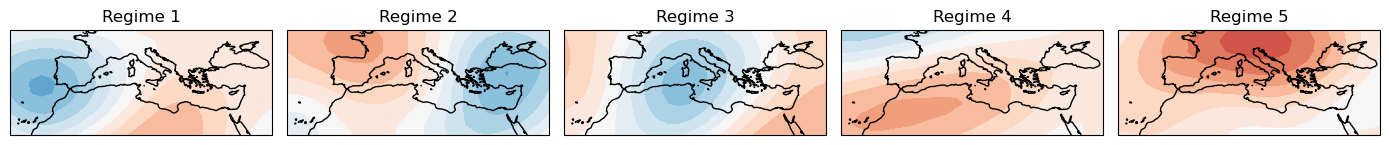

In [20]:
cluster_centers_concat = xr.concat(cluster_centers, "start_date")
s2s_cluster_centers = cluster_centers_concat.mean(dim='start_date')

s2s_cluster_centers_flat = cf.reshape_data_for_clustering(s2s_cluster_centers)
s2s_cluster_centers_flat_df = pd.DataFrame(s2s_cluster_centers_flat.transpose())
s2s_cluster_centers_flat_df.to_csv('results.nosync/s2s_results/s2s_cmmvae_cluster_centers.csv')

cca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = s2s_cluster_centers, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-2, vmax=2, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [2, 1, 0, 4, 3],
                                         projection = ccrs.PlateCarree(central_longitude=0))

#plt.savefig('results.nosync/s2s_results/s2s_cmmvae_cluster_centers.png')

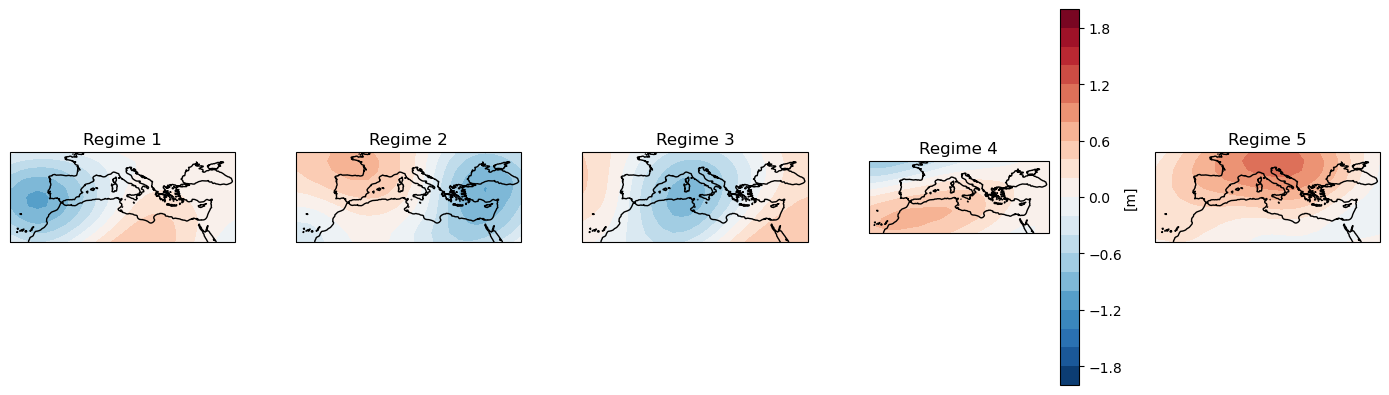

In [23]:

cca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = s2s_cluster_centers, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-2, vmax=2.2, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [2, 1, 0, 4, 3],
                                         projection = ccrs.PlateCarree(central_longitude=0))